# Packages importation 

In [1]:
import numpy as np
import os
import kagglehub
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.model_selection import KFold, train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from BGE_Adam import BGE_Adam
from training import train
from models import LogisticRegressionTorch, SimpleNN, ComplexNN
from training_validation import training_validation, Trainer
from evaluation import evaluate, evaluate_model
from test import Trainer
from Cross_Validate_Hyperparams import cross_validate_hyperparams, cross_validate_accuracy

# The MNIST database

In [5]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


In [6]:
def load_mnist_images(file_path):
    """Loads MNIST images from a ubyte file."""
    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')  # Magic number
        num_images = int.from_bytes(f.read(4), 'big')    # Number of images 
        num_rows = int.from_bytes(f.read(4), 'big')      # Number of rows per image
        num_cols = int.from_bytes(f.read(4), 'big')      # Number of columns per image
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

In [7]:
def load_mnist_labels(file_path):
    """Loads MNIST labels from a ubyte file."""
    with open(file_path, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')  # Magic number
        num_labels = int.from_bytes(f.read(4), 'big')   # Labels number
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

In [8]:
train_images_path = os.path.join(path, "train-images.idx3-ubyte")
train_labels_path = os.path.join(path, "train-labels.idx1-ubyte")
test_images_path = os.path.join(path, "t10k-images.idx3-ubyte")
test_labels_path = os.path.join(path, "t10k-labels.idx1-ubyte")

In [9]:
# Loading the data
X_train = load_mnist_images(train_images_path)
y_train = load_mnist_labels(train_labels_path)
X_test = load_mnist_images(test_images_path)
y_test = load_mnist_labels(test_labels_path)

In [10]:
# Data preprocessing
# Flatten and normalize images
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Convert labels to One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Check new shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (60000, 784), y_train shape: (60000, 10)
X_test shape: (10000, 784), y_test shape: (10000, 10)


In [11]:
# Choose of the ratio for the validation set
validation_ratio = 0.2

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(np.argmax(y_valid, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

# Check the shapes
print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_valid shape: {X_valid_tensor.shape}, y_valid shape: {y_valid_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")


X_train shape: torch.Size([48000, 784]), y_train shape: torch.Size([48000])
X_valid shape: torch.Size([12000, 784]), y_valid shape: torch.Size([12000])
X_test shape: torch.Size([10000, 784]), y_test shape: torch.Size([10000])


Without validation dataset:

\#Convert data into PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)  

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

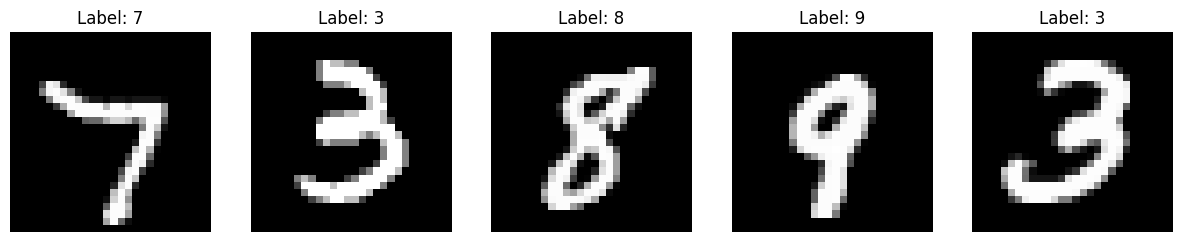

In [12]:
# Visualize some images
def plot_mnist_images(X, y, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = X[i].view(28, 28).detach().numpy()  # Reshape the image to 28x28
        label = y[i].item()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Call the function to plot the images
plot_mnist_images(X_valid_tensor, y_valid_tensor)

In [ ]:
print(f"Total number of training examples : {X_train.shape[0]}")
print(f"Total number of validation examples : {X_valid.shape[0]}")
print(f"Total number of test examples : {X_test.shape[0]}")
print(f"Shape of the images : {X_train.shape[1]} (28x28 pixels)")
print(f"Number of classes : {len(torch.unique(y_train_tensor))}")

Total number of training examples : 48000
Total number of validation examples : 12000
Total number of test examples : 10000
Shape of the images : 784 (28x28 pixels)
Number of classes : 10


In [14]:
# Simple statistics on the dataset
print(f"Minimal value of the pixels : {X_train_tensor.min().item()}")
print(f"Maximal value of the pixels : {X_train_tensor.max().item()}")
print(f"Average of the pixels : {X_train_tensor.float().mean().item()}")
print(f"Standard-error of the pixels : {X_train_tensor.float().std().item()}")

Minimal value of the pixels : 0.0
Maximal value of the pixels : 1.0
Average of the pixels : 0.13074526190757751
Standard-error of the pixels : 0.30821332335472107


# Search of the optimal hyperparameters

In [17]:
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

In [18]:
# Combine training and validation for final training
X_combined = torch.cat([X_train_tensor, X_valid_tensor], dim=0)
y_combined = torch.cat([y_train_tensor, y_valid_tensor], dim=0)

In [19]:
models = {
    'LogisticRegression': LogisticRegressionTorch,
    'SimpleNN': SimpleNN,
    'ComplexNN': ComplexNN
}

optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

hyperparams = {
    'Adam': [{'lr': 0.001, 'betas': (0.9, 0.999)}, {'lr': 0.0005, 'betas': (0.85, 0.995)}],
    'SGD': [{'lr': 0.01, 'momentum': 0.9}, {'lr': 0.005, 'momentum': 0.95}]
}

# Table 1 : Hyperparameters (cross-entropy loss)
hyperparams_results = {}
with tqdm(total=len(models) * len(optimizers), desc="Global search of the hyperparamèeters") as pbar:
    for model_name, model_class in models.items():
        for opt_name, opt_class in optimizers.items():
            best_params, _ = cross_validate_hyperparams(
                model_class, opt_class, X_combined, y_combined, hyperparams[opt_name], input_dim, num_classes
            )
            hyperparams_results[f'{model_name}_{opt_name}'] = best_params
            pbar.update(1)

# Table 2 : Average accuracy (rate of correct predictions)
accuracy_results = {}
with tqdm(total=len(models) * len(optimizers), desc="Global validation") as pbar:
    for model_name, model_class in models.items():
        for opt_name, opt_class in optimizers.items():
            accuracy = cross_validate_accuracy(
                model_class, opt_class, X_combined, y_combined, hyperparams_results[f'{model_name}_{opt_name}'], input_dim, num_classes
            )
            accuracy_results[f'{model_name}_{opt_name}'] = accuracy
            pbar.update(1)

# Affichage des résultats
print("Table 1 : Hyperparameters")
print(hyperparams_results)
print("\nTable 2 : Average accuracy")
print(accuracy_results)

Global validation: 100%|██████████| 6/6 [07:13<00:00, 72.22s/it]

Table 1 : Hyperparameters
{'LogisticRegression_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'LogisticRegression_SGD': {'lr': 0.01, 'momentum': 0.9}, 'SimpleNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'SimpleNN_SGD': {'lr': 0.01, 'momentum': 0.9}, 'ComplexNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'ComplexNN_SGD': {'lr': 0.01, 'momentum': 0.9}}

Table 2 : Average accuracy
{'LogisticRegression_Adam': 0.6228833377361298, 'LogisticRegression_SGD': 0.6105333268642426, 'SimpleNN_Adam': 0.665666651725769, 'SimpleNN_SGD': 0.26158333420753477, 'ComplexNN_Adam': 0.39226666986942293, 'ComplexNN_SGD': 0.10636666715145111}


In [15]:
hyperparams_results = {'LogisticRegression_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'LogisticRegression_SGD': {'lr': 0.01, 'momentum': 0.9}, 'SimpleNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'SimpleNN_SGD': {'lr': 0.01, 'momentum': 0.9}, 'ComplexNN_Adam': {'lr': 0.001, 'betas': (0.9, 0.999)}, 'ComplexNN_SGD': {'lr': 0.01, 'momentum': 0.9}}
accuracy_results = {'LogisticRegression_Adam': 0.6228833377361298, 'LogisticRegression_SGD': 0.6105333268642426, 'SimpleNN_Adam': 0.665666651725769, 'SimpleNN_SGD': 0.26158333420753477, 'ComplexNN_Adam': 0.39226666986942293, 'ComplexNN_SGD': 0.10636666715145111}

# Logistic regression

### Training with validation

In [35]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = LogisticRegressionTorch(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/20, Train Loss: 0.3724, Val Loss: 0.3179, Val Accuracy: 0.9128
Epoch 2/20, Train Loss: 0.3221, Val Loss: 0.3323, Val Accuracy: 0.9160
Epoch 3/20, Train Loss: 0.3157, Val Loss: 0.3611, Val Accuracy: 0.9058
Epoch 4/20, Train Loss: 0.3184, Val Loss: 0.3419, Val Accuracy: 0.9116
Epoch 5/20, Train Loss: 0.3158, Val Loss: 0.3429, Val Accuracy: 0.9166
Epoch 6/20, Train Loss: 0.3164, Val Loss: 0.3491, Val Accuracy: 0.9172
Epoch 7/20, Train Loss: 0.3168, Val Loss: 0.3589, Val Accuracy: 0.9163
Epoch 8/20, Train Loss: 0.3156, Val Loss: 0.3643, Val Accuracy: 0.9169
Epoch 9/20, Train Loss: 0.3153, Val Loss: 0.3696, Val Accuracy: 0.9158
Epoch 10/20, Train Loss: 0.3187, Val Loss: 0.3929, Val Accuracy: 0.9097
Epoch 11/20, Train Loss: 0.3169, Val Loss: 0.3731, Val Accuracy: 0.9132
Epoch 12/20, Train Loss: 0.3167, Val Loss: 0.3991, Val Accuracy: 0.9083
Epoch 13/20, Train Loss: 0.3183, Val Loss: 0.3801, Val Accuracy: 0.9168
Epoch 14/20, Train Loss: 0.3195, Val Loss: 0.3732, Val Accuracy: 0.9151
E

In [175]:
accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9163


In [176]:
evaluate(model, X_test_tensor, y_test_tensor)

Test Accuracy: 0.9163


In [179]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 0.3217, Val Loss: 0.4223, Val Accuracy: 0.9047
Epoch 2/20, Train Loss: 0.3056, Val Loss: 0.3934, Val Accuracy: 0.9095
Epoch 3/20, Train Loss: 0.2963, Val Loss: 0.3819, Val Accuracy: 0.9080
Epoch 4/20, Train Loss: 0.2892, Val Loss: 0.3767, Val Accuracy: 0.9086
Epoch 5/20, Train Loss: 0.2860, Val Loss: 0.3764, Val Accuracy: 0.9119
Epoch 6/20, Train Loss: 0.2866, Val Loss: 0.3998, Val Accuracy: 0.9013
Epoch 7/20, Train Loss: 0.2817, Val Loss: 0.3729, Val Accuracy: 0.9112
Epoch 8/20, Train Loss: 0.2792, Val Loss: 0.3564, Val Accuracy: 0.9158
Epoch 9/20, Train Loss: 0.2811, Val Loss: 0.3688, Val Accuracy: 0.9113
Epoch 10/20, Train Loss: 0.2769, Val Loss: 0.3607, Val Accuracy: 0.9135
Epoch 11/20, Train Loss: 0.2722, Val Loss: 0.3775, Val Accuracy: 0.9065
Epoch 12/20, Train Loss: 0.2734, Val Loss: 0.3756, Val Accuracy: 0.9076
Epoch 13/20, Train Loss: 0.2714, Val Loss: 0.3737, Val Accuracy: 0.9110
Epoch 14/20, Train Loss: 0.2676, Val Loss: 0.3692, Val Accuracy: 0.9112
E

In [180]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 0.2253, Val Loss: 0.3469, Val Accuracy: 0.9162
Epoch 2/20, Train Loss: 0.2202, Val Loss: 0.3445, Val Accuracy: 0.9164
Epoch 3/20, Train Loss: 0.2182, Val Loss: 0.3428, Val Accuracy: 0.9172
Epoch 4/20, Train Loss: 0.2167, Val Loss: 0.3415, Val Accuracy: 0.9179
Epoch 5/20, Train Loss: 0.2154, Val Loss: 0.3407, Val Accuracy: 0.9178
Epoch 6/20, Train Loss: 0.2144, Val Loss: 0.3400, Val Accuracy: 0.9182
Epoch 7/20, Train Loss: 0.2136, Val Loss: 0.3392, Val Accuracy: 0.9186
Epoch 8/20, Train Loss: 0.2129, Val Loss: 0.3388, Val Accuracy: 0.9184
Epoch 9/20, Train Loss: 0.2123, Val Loss: 0.3385, Val Accuracy: 0.9193
Epoch 10/20, Train Loss: 0.2118, Val Loss: 0.3382, Val Accuracy: 0.9197
Epoch 11/20, Train Loss: 0.2113, Val Loss: 0.3378, Val Accuracy: 0.9196
Epoch 12/20, Train Loss: 0.2110, Val Loss: 0.3374, Val Accuracy: 0.9196
Epoch 13/20, Train Loss: 0.2106, Val Loss: 0.3372, Val Accuracy: 0.9200
Epoch 14/20, Train Loss: 0.2103, Val Loss: 0.3373, Val Accuracy: 0.9193
E

In [34]:
# Données
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=LogisticRegressionTorch,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=20,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

TypeError: Trainer.compare_optimizers() got an unexpected keyword argument 'hyperparams_results'

# Simple neural network

## BGE-Adam optimizer

In [181]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = SimpleNN(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

In [182]:
# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 0.2626, Val Loss: 0.1622, Val Accuracy: 0.9533
Epoch 2/20, Train Loss: 0.1522, Val Loss: 0.1441, Val Accuracy: 0.9631
Epoch 3/20, Train Loss: 0.1303, Val Loss: 0.1789, Val Accuracy: 0.9611
Epoch 4/20, Train Loss: 0.1234, Val Loss: 0.2056, Val Accuracy: 0.9622
Epoch 5/20, Train Loss: 0.1133, Val Loss: 0.1950, Val Accuracy: 0.9650
Epoch 6/20, Train Loss: 0.0999, Val Loss: 0.2341, Val Accuracy: 0.9631
Epoch 7/20, Train Loss: 0.1016, Val Loss: 0.2556, Val Accuracy: 0.9657
Epoch 8/20, Train Loss: 0.0908, Val Loss: 0.2644, Val Accuracy: 0.9654
Epoch 9/20, Train Loss: 0.0884, Val Loss: 0.2462, Val Accuracy: 0.9645
Epoch 10/20, Train Loss: 0.0880, Val Loss: 0.3142, Val Accuracy: 0.9638
Epoch 11/20, Train Loss: 0.0804, Val Loss: 0.3475, Val Accuracy: 0.9651
Epoch 12/20, Train Loss: 0.0760, Val Loss: 0.3100, Val Accuracy: 0.9679
Epoch 13/20, Train Loss: 0.0720, Val Loss: 0.3348, Val Accuracy: 0.9669
Epoch 14/20, Train Loss: 0.0710, Val Loss: 0.3381, Val Accuracy: 0.9654
E

## Adam optimizer

In [183]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 0.1125, Val Loss: 0.4802, Val Accuracy: 0.9594
Epoch 2/20, Train Loss: 0.1015, Val Loss: 0.4549, Val Accuracy: 0.9607
Epoch 3/20, Train Loss: 0.0943, Val Loss: 0.4435, Val Accuracy: 0.9603
Epoch 4/20, Train Loss: 0.0917, Val Loss: 0.4327, Val Accuracy: 0.9628
Epoch 5/20, Train Loss: 0.0836, Val Loss: 0.4914, Val Accuracy: 0.9605
Epoch 6/20, Train Loss: 0.0758, Val Loss: 0.4392, Val Accuracy: 0.9656
Epoch 7/20, Train Loss: 0.0744, Val Loss: 0.4779, Val Accuracy: 0.9653
Epoch 8/20, Train Loss: 0.0701, Val Loss: 0.4651, Val Accuracy: 0.9632
Epoch 9/20, Train Loss: 0.0723, Val Loss: 0.4906, Val Accuracy: 0.9614
Epoch 10/20, Train Loss: 0.0701, Val Loss: 0.4938, Val Accuracy: 0.9641
Epoch 11/20, Train Loss: 0.0695, Val Loss: 0.4435, Val Accuracy: 0.9670
Epoch 12/20, Train Loss: 0.0529, Val Loss: 0.4722, Val Accuracy: 0.9638
Epoch 13/20, Train Loss: 0.0716, Val Loss: 0.5219, Val Accuracy: 0.9663
Epoch 14/20, Train Loss: 0.0636, Val Loss: 0.4924, Val Accuracy: 0.9653
E

## SGD optimizer

In [184]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 0.0318, Val Loss: 0.5344, Val Accuracy: 0.9686
Epoch 2/20, Train Loss: 0.0226, Val Loss: 0.5216, Val Accuracy: 0.9692
Epoch 3/20, Train Loss: 0.0187, Val Loss: 0.5144, Val Accuracy: 0.9697
Epoch 4/20, Train Loss: 0.0162, Val Loss: 0.5098, Val Accuracy: 0.9699
Epoch 5/20, Train Loss: 0.0143, Val Loss: 0.5074, Val Accuracy: 0.9699
Epoch 6/20, Train Loss: 0.0130, Val Loss: 0.5045, Val Accuracy: 0.9700
Epoch 7/20, Train Loss: 0.0119, Val Loss: 0.5021, Val Accuracy: 0.9702
Epoch 8/20, Train Loss: 0.0110, Val Loss: 0.5005, Val Accuracy: 0.9701
Epoch 9/20, Train Loss: 0.0101, Val Loss: 0.4991, Val Accuracy: 0.9702
Epoch 10/20, Train Loss: 0.0094, Val Loss: 0.4983, Val Accuracy: 0.9704
Epoch 11/20, Train Loss: 0.0088, Val Loss: 0.4970, Val Accuracy: 0.9706
Epoch 12/20, Train Loss: 0.0082, Val Loss: 0.4963, Val Accuracy: 0.9706
Epoch 13/20, Train Loss: 0.0077, Val Loss: 0.4955, Val Accuracy: 0.9706
Epoch 14/20, Train Loss: 0.0073, Val Loss: 0.4945, Val Accuracy: 0.9708
E

In [ ]:
# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=SimpleNN,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=20,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Complex neural network

## BGE-Adam optimizer

In [185]:
# Model parameters
input_dim = X_train.shape[1]  # 784
num_classes = y_train.shape[1]  # 10

# Initializing the model, optimizer and loss function
model = ComplexNN(input_dim, num_classes)
optimizer = BGE_Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

In [186]:
# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20, Train Loss: 0.6669, Val Loss: 0.2646, Val Accuracy: 0.9337
Epoch 2/20, Train Loss: 0.5008, Val Loss: 0.2664, Val Accuracy: 0.9367
Epoch 3/20, Train Loss: 0.4846, Val Loss: 0.2588, Val Accuracy: 0.9344
Epoch 4/20, Train Loss: 0.4838, Val Loss: 0.2585, Val Accuracy: 0.9379
Epoch 5/20, Train Loss: 0.4731, Val Loss: 0.2631, Val Accuracy: 0.9370
Epoch 6/20, Train Loss: 0.4670, Val Loss: 0.2422, Val Accuracy: 0.9431
Epoch 7/20, Train Loss: 0.4763, Val Loss: 0.2536, Val Accuracy: 0.9442
Epoch 8/20, Train Loss: 0.4785, Val Loss: 0.2444, Val Accuracy: 0.9400
Epoch 9/20, Train Loss: 0.4775, Val Loss: 0.2319, Val Accuracy: 0.9430
Epoch 10/20, Train Loss: 0.4690, Val Loss: 0.2561, Val Accuracy: 0.9427
Epoch 11/20, Train Loss: 0.4771, Val Loss: 0.2473, Val Accuracy: 0.9456
Epoch 12/20, Train Loss: 0.4814, Val Loss: 0.2658, Val Accuracy: 0.9444
Epoch 13/20, Train Loss: 0.4928, Val Loss: 0.2565, Val Accuracy: 0.9473
Epoch 14/20, Train Loss: 0.5036, Val Loss: 0.2608, Val Accuracy: 0.9448
E

## Adam optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

## SGD optimizer

In [ ]:
# Données
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=LogisticRegressionTorch,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=20,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    X_test=X_test_tensor, 
    y_test=y_test_tensor
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training and validation
train_losses, val_losses, val_accuracies = training_validation(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
                         epochs=20, batch_size=64)

# Final results
print("Training completed.")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Liste des optimiseurs
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'BGE_Adam': BGE_Adam
}

# Création de l'objet Trainer
trainer = Trainer(
    model_class=ComplexNN,
    input_dim=input_dim,
    num_classes=num_classes,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizers=optimizers,
    epochs=20,
    batch_size=64
)

# Comparaison des optimiseurs
results = trainer.compare_optimizers(
    X_train=X_train_tensor, 
    y_train=y_train_tensor, 
    X_valid=X_valid_tensor, 
    y_valid=y_valid_tensor,
    hyperparams_results=hyperparams_results
)

# Comparison of BGE-Adam with Adam and SGD

In [2]:
from utils import compare_optimizers

In [3]:
# Configurer les paramètres du modèle
input_dim = X_train_tensor.shape[1]
num_classes = len(torch.unique(y_train_tensor))

# Appeler la comparaison des optimiseurs
compare_optimizers(
    LogisticRegressionTorch, 
    input_dim, 
    num_classes, 
    X_train_tensor, 
    y_train_tensor, 
    X_test_tensor, 
    y_test_tensor
)

NameError: name 'X_train_tensor' is not defined

Comparison with cross validation

In [191]:
def cross_validate_optimizer(optimizer_class, model_class, X_train, y_train, k_folds=5, **kwargs):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_results = []

    criterion = torch.nn.CrossEntropyLoss()
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        print(f'Fold {fold + 1}/{k_folds}')
        
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]
        
        model = model_class(input_dim, num_classes)
        optimizer = optimizer_class(model.parameters(), **kwargs)
        
        for epoch in range(5):  # Short training per fold
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_fold)
            loss = criterion(outputs, y_train_fold)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            val_loss = criterion(val_outputs, y_val_fold).item()
            fold_results.append(val_loss)

    return sum(fold_results) / len(fold_results)  # Mean validation loss across folds


Evaluating SGD...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Evaluating Adam...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Evaluating BGE_Adam...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


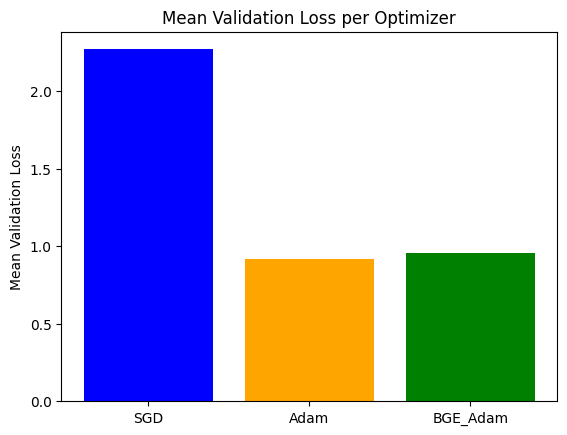

In [192]:
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'BGE_Adam': BGE_Adam
}

results = {}
for name, opt_class in optimizers.items():
    print(f'Evaluating {name}...')
    results[name] = cross_validate_optimizer(opt_class, LogisticRegressionTorch, X_train_tensor, y_train_tensor, lr=0.01)

# Affichage des résultats
plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.title('Mean Validation Loss per Optimizer')
plt.ylabel('Mean Validation Loss')
plt.show()


In [193]:
def evaluate_generalization(model_class, optimizer_class, X_train, y_train, X_test, y_test, **kwargs):
    model = model_class(input_dim, num_classes)
    optimizer = optimizer_class(model.parameters(), **kwargs)
    criterion = torch.nn.CrossEntropyLoss()

    # Training
    model.train()
    for epoch in range(10):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluation over the test 
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        test_predictions = torch.argmax(test_outputs, dim=1)
        test_accuracy = (test_predictions == y_test).float().mean().item()

    return test_loss, test_accuracy

# Comparison 
for name, opt_class in optimizers.items():
    print(f'Evaluating {name}...')
    loss, accuracy = evaluate_generalization(
        LogisticRegressionTorch, opt_class, 
        X_train_tensor, y_train_tensor, 
        X_test_tensor, y_test_tensor, 
        lr=0.01
    )
    print(f"{name}: Loss = {loss:.4f}, Accuracy = {accuracy:.4%}")


Evaluating SGD...
SGD: Loss = 2.2217, Accuracy = 21.1600%
Evaluating Adam...
Adam: Loss = 0.5573, Accuracy = 85.1400%
Evaluating BGE_Adam...
BGE_Adam: Loss = 0.6577, Accuracy = 86.1300%


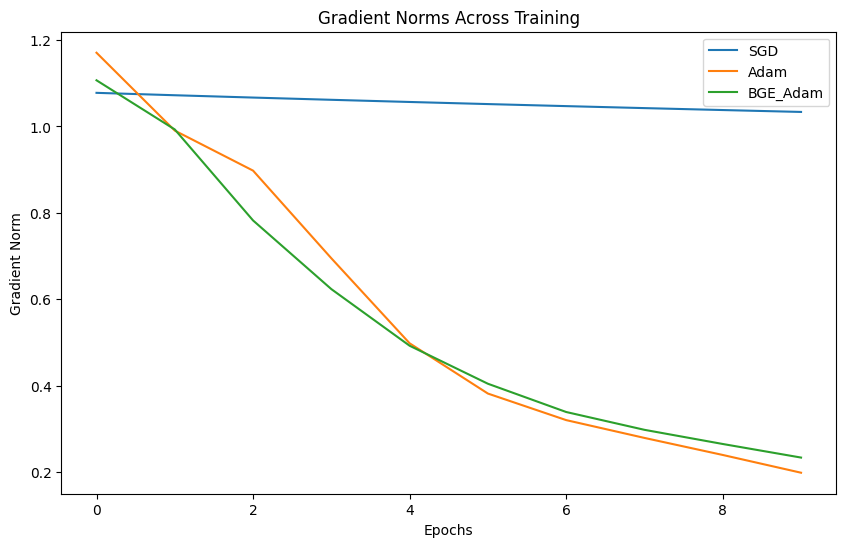

In [194]:
def track_gradient_norms(model_class, optimizer_class, X_train, y_train, **kwargs):
    model = model_class(input_dim, num_classes)
    optimizer = optimizer_class(model.parameters(), **kwargs)
    criterion = torch.nn.CrossEntropyLoss()

    grad_norms = []
    for epoch in range(10):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()

        # Calculer et enregistrer la norme des gradients
        total_grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
        grad_norms.append(total_grad_norm)

        optimizer.step()
    
    return grad_norms

# Affichage des normes de gradients pour chaque optimiseur
plt.figure(figsize=(10, 6))
for name, opt_class in optimizers.items():
    grad_norms = track_gradient_norms(LogisticRegressionTorch, opt_class, X_train_tensor, y_train_tensor, lr=0.01)
    plt.plot(grad_norms, label=name)

plt.title('Gradient Norms Across Training')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()


Evaluating SGD...
Evaluating Adam...
Evaluating BGE_Adam...


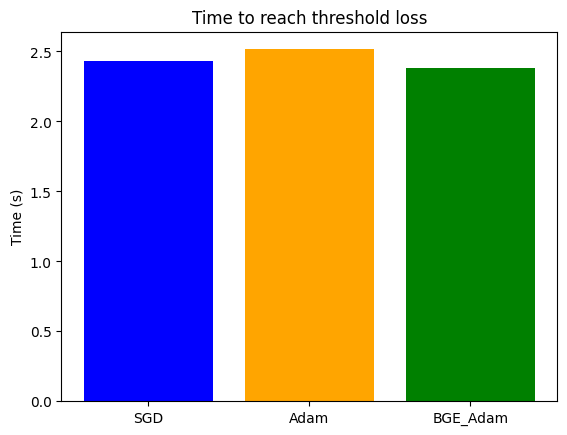

In [195]:
def run_optimizer_with_time_check(optimizer_class, model, X_train, y_train, threshold_loss, **kwargs):
    optimizer = optimizer_class(model.parameters(), **kwargs)
    criterion = torch.nn.CrossEntropyLoss()
    start_time = time.time()
    
    for epoch in range(10):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if loss.item() < threshold_loss:
            return time.time() - start_time

    return time.time() - start_time

# Comparison of threshold times
threshold_loss = 0.2
times = {}
for name, opt_class in optimizers.items():
    print(f'Evaluating {name}...')
    time_taken = run_optimizer_with_time_check(
        opt_class, LogisticRegressionTorch(input_dim, num_classes), 
        X_train_tensor, y_train_tensor, threshold_loss, lr=0.01
    )
    times[name] = time_taken

plt.bar(times.keys(), times.values(), color=['blue', 'orange', 'green'])
plt.title('Time to reach threshold loss')
plt.ylabel('Time (s)')
plt.show()


### Comparison of training loss and accuracy

In [196]:
def evaluate_optimizer(model_class, optimizer_class, X_train, y_train, X_test, y_test, lr, num_epochs=10):
    model = model_class(input_dim, num_classes)
    optimizer = optimizer_class(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_predictions = torch.argmax(test_outputs, dim=1)
            test_accuracy = (test_predictions == y_test).float().mean().item()
            test_accuracies.append(test_accuracy)

    return train_losses, test_accuracies


In [197]:
def compare_optimizers_with_accuracy(model_class, X_train, y_train, X_test, y_test, lr, num_epochs=10):
    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'BGE_Adam': BGE_Adam
    }

    results = {}

    for name, optimizer_class in optimizers.items():
        print(f'Evaluating {name}...')
        train_losses, test_accuracies = evaluate_optimizer(
            model_class, optimizer_class, 
            X_train, y_train, X_test, y_test, 
            lr=lr, num_epochs=num_epochs
        )
        results[name] = {
            'train_losses': train_losses,
            'test_accuracies': test_accuracies
        }

    # Plot the results
    plt.figure(figsize=(14, 6))

    # Training loss
    plt.subplot(1, 2, 1)
    for name, result in results.items():
        plt.plot(result['train_losses'], label=name)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy over the test
    plt.subplot(1, 2, 2)
    for name, result in results.items():
        plt.plot(result['test_accuracies'], label=name)
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final results
    final_results = {name: result['test_accuracies'][-1] for name, result in results.items()}
    for name, accuracy in final_results.items():
        print(f'{name}: Final test accuracy = {accuracy:.4%}')


Evaluating SGD...
Evaluating Adam...
Evaluating BGE_Adam...


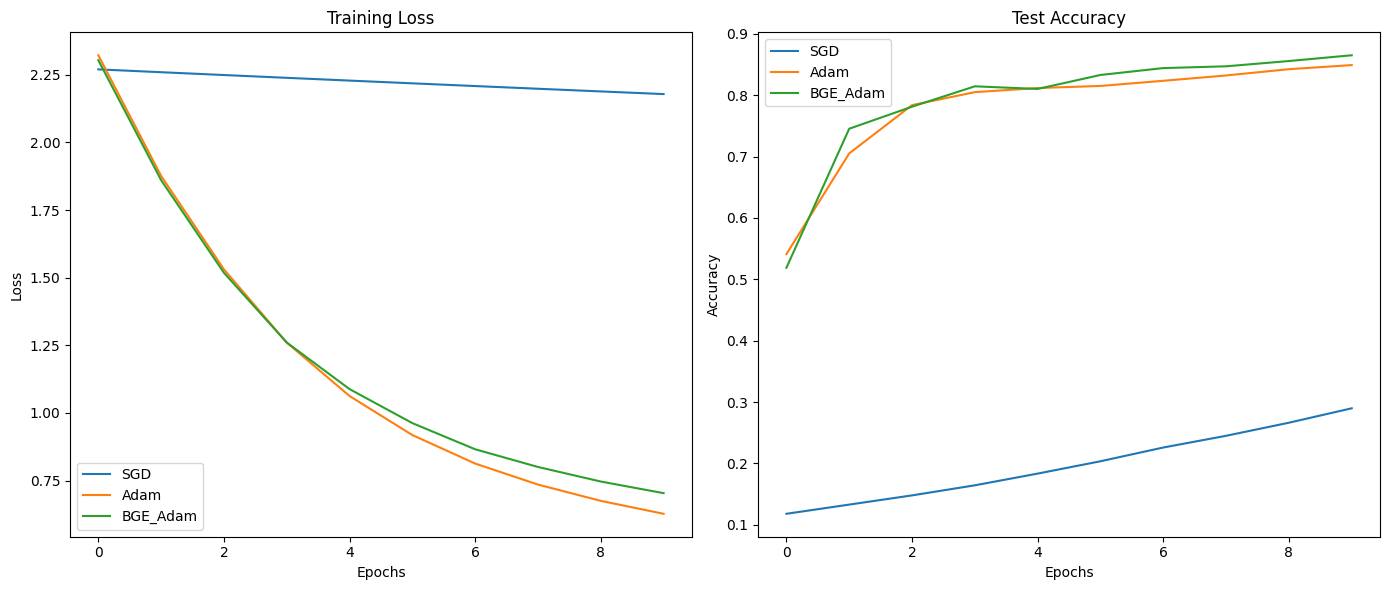

SGD: Final test accuracy = 28.9900%
Adam: Final test accuracy = 84.9100%
BGE_Adam: Final test accuracy = 86.5100%


In [198]:
# Initialisation des paramètres
input_dim = 28 * 28  # Dimension des données MNIST aplaties
num_classes = 10     # Nombre de classes
lr = 0.01            # Taux d'apprentissage
num_epochs = 10      # Nombre d'époques d'entraînement

# Convertir les données MNIST en tenseurs Torch
X_train_tensor = X_train_tensor.view(-1, 28 * 28).float()
y_train_tensor = y_train_tensor.long()
X_test_tensor = X_test_tensor.view(-1, 28 * 28).float()
y_test_tensor = y_test_tensor.long()

# Comparaison des optimiseurs
compare_optimizers_with_accuracy(LogisticRegressionTorch, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, lr, num_epochs)

In [200]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).float().mean().item()

In [202]:
def precision(y_true, y_pred):
    return precision_score(y_true.numpy(), y_pred.numpy(), average='weighted', zero_division=1)

In [203]:
def recall(y_true, y_pred):
    return recall_score(y_true.numpy(), y_pred.numpy(), average='weighted', zero_division=1)


In [204]:
def f1_score_metric(y_true, y_pred):
    return f1_score(y_true.numpy(), y_pred.numpy(), average='weighted', zero_division=1)

In [205]:
def run_optimizer(optimizer_class, model, X_train, y_train, X_test, y_test, num_epochs, lr):
    optimizer = optimizer_class(model.parameters(), lr=lr)
    losses = []
    all_accuracy = []
    all_precision = []
    all_recall = []
    all_f1_score = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = torch.nn.functional.cross_entropy(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test)
            _, y_pred = torch.max(outputs_test, 1)
            accuracy_val = accuracy(y_test, y_pred)
            precision_val = precision(y_test, y_pred)
            recall_val = recall(y_test, y_pred)
            f1_val = f1_score_metric(y_test, y_pred)

            all_accuracy.append(accuracy_val)
            all_precision.append(precision_val)
            all_recall.append(recall_val)
            all_f1_score.append(f1_val)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    return all_accuracy, all_precision, all_recall, all_f1_score

# Comparaison des optimiseurs
num_epochs = 10
lr = 0.001

results_sgd = run_optimizer(torch.optim.SGD, model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs, lr)
results_adam = run_optimizer(torch.optim.Adam, model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs, lr)
results_bge_adam = run_optimizer(BGE_Adam, model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs, lr)


Epoch 1/10, Loss: 0.4789876341819763
Epoch 2/10, Loss: 0.46816715598106384
Epoch 3/10, Loss: 0.49798083305358887
Epoch 4/10, Loss: 0.48481419682502747
Epoch 5/10, Loss: 0.48080915212631226
Epoch 6/10, Loss: 0.4748058319091797
Epoch 7/10, Loss: 0.4956200420856476
Epoch 8/10, Loss: 0.4918159246444702
Epoch 9/10, Loss: 0.4903280436992645
Epoch 10/10, Loss: 0.48211321234703064
Epoch 1/10, Loss: 0.47118785977363586
Epoch 2/10, Loss: 0.46524760127067566
Epoch 3/10, Loss: 0.45404642820358276
Epoch 4/10, Loss: 0.4467705488204956
Epoch 5/10, Loss: 0.4201251268386841
Epoch 6/10, Loss: 0.42236328125
Epoch 7/10, Loss: 0.4121055006980896
Epoch 8/10, Loss: 0.40384212136268616
Epoch 9/10, Loss: 0.40417978167533875
Epoch 10/10, Loss: 0.3940989673137665
Epoch 1/10, Loss: 0.3969237506389618
Epoch 2/10, Loss: 0.3911937177181244
Epoch 3/10, Loss: 0.38419368863105774
Epoch 4/10, Loss: 0.37985342741012573
Epoch 5/10, Loss: 0.3808380663394928
Epoch 6/10, Loss: 0.3709046244621277
Epoch 7/10, Loss: 0.377431154

In [206]:
print("\nBGE_Adam Results:")
print(f"Accuracy: {results_bge_adam[0][-1]}")
print(f"Precision: {results_bge_adam[1][-1]}")
print(f"Recall: {results_bge_adam[2][-1]}")
print(f"F1 Score: {results_bge_adam[3][-1]}")


BGE_Adam Results:
Accuracy: 0.9552000164985657
Precision: 0.9554530657436117
Recall: 0.9552
F1 Score: 0.9552394375189047


In [207]:
print("\nAdam Results:")
print(f"Accuracy: {results_adam[0][-1]}")
print(f"Precision: {results_adam[1][-1]}")
print(f"Recall: {results_adam[2][-1]}")
print(f"F1 Score: {results_adam[3][-1]}")


Adam Results:
Accuracy: 0.953000009059906
Precision: 0.9532549643526709
Recall: 0.953
F1 Score: 0.9530237951738701


In [208]:
# Affichage des résultats
print("SGD Results:")
print(f"Accuracy: {results_sgd[0][-1]}")
print(f"Precision: {results_sgd[1][-1]}")
print(f"Recall: {results_sgd[2][-1]}")
print(f"F1 Score: {results_sgd[3][-1]}")


SGD Results:
Accuracy: 0.9502000212669373
Precision: 0.9509959083997436
Recall: 0.9502
F1 Score: 0.9502817252928538


In [ ]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class Evaluator:
    def __init__(self, model_class, input_dim, num_classes, lr=0.01, num_epochs=10):
        self.model_class = model_class
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.lr = lr
        self.num_epochs = num_epochs

    def evaluate(self, optimizer_class, X_train, y_train, X_test, y_test):
        optimizer = optimizer_class(self.model_class(self.input_dim, self.num_classes).parameters(), lr=self.lr)
        model = self.model_class(self.input_dim, self.num_classes)

        criterion = torch.nn.CrossEntropyLoss()
        all_accuracy = []
        all_precision = []
        all_recall = []
        all_f1_score = []

        for epoch in range(self.num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            # Evaluation
            model.eval()
            with torch.no_grad():
                outputs_test = model(X_test)
                _, y_pred = torch.max(outputs_test, 1)
                accuracy_val = accuracy(y_test, y_pred)
                precision_val = precision(y_test, y_pred)
                recall_val = recall(y_test, y_pred)
                f1_val = f1_score_metric(y_test, y_pred)

                all_accuracy.append(accuracy_val)
                all_precision.append(precision_val)
                all_recall.append(recall_val)
                all_f1_score.append(f1_val)

        return {
            'accuracy': all_accuracy,
            'precision': all_precision,
            'recall': all_recall,
            'f1_score': all_f1_score
        }

# Exemple d'utilisation
evaluator = Evaluator(LogisticRegressionTorch, input_dim, num_classes)
results_sgd = evaluator.evaluate(torch.optim.SGD, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
results_adam = evaluator.evaluate(torch.optim.Adam, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
results_bge_adam = evaluator.evaluate(BGE_Adam, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

print("SGD Results:", results_sgd)
print("Adam Results:", results_adam)
print("BGE_Adam Results:", results_bge_adam)

SGD Results: {'accuracy': [0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104, 0.15940000116825104], 'precision': [0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657, 0.10154309194532657], 'recall': [0.1594, 0.1594, 0.1594, 0.1594, 0.1594, 0.1594, 0.1594, 0.1594, 0.1594, 0.1594], 'f1_score': [0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524, 0.10960281881050524]}
Adam Results: {'accuracy': [0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09600000083446503, 0.09